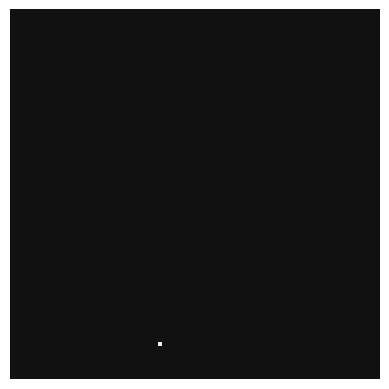

策略变换次数： 93
策略 0 占比 0.010%  策略 1 占比 99.990%  
策略 0 平均收益 -1.4000000000000001 最大收益 0.0
策略 1 平均收益 0.0014401440144014403 最大收益 1.44
演化在第 94 轮，策略统一为 1，停止演化
{(3.6, 1, 1): (np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(13.0), np.float64(0.0013), None, np.float64(0.0013), None, None, np.float64(0.0013), None, None, None, None)}
(np.float64(0.1037), np.float64(0.8963), np.float64(0.0), np.float64(13481.0), np.float64(1.3481), np.float64(3.0755255544840883), np.float64(1.1482405444605601), None)
#


In [1]:

import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
import math

from matplotlib.colors import LinearSegmentedColormap

# 定义两个线性分段的颜色映射
colors = [(48, 83, 133), (218, 160, 90), (253, 243, 197)]  # R -> G -> B
colors = [(color[0] / 255, color[1] / 255, color[2] / 255) for color in colors]
cmap_mma = LinearSegmentedColormap.from_list("mma", colors, N=256)

# 定义另一个颜色映射
colors = ["#eeeeee", "#111111", "#787ac0", ]
cmap = mpl.colors.ListedColormap(colors, N=3)

# 定义一个函数，用于计算邻居之间的重叠情况，数组的五邻居总和，用于计算个体周围的邻居数量。
overlap5 = lambda A: A + np.roll(A, -1, 0) + np.roll(A, 1, 0) + np.roll(A, -1, 1) + np.roll(A, 1, 1)


# 定义一个函数，用于过滤出数组中的正值
positive_filter = lambda A: (A > 0) * A


class SPGG:


    def __init__(self,q,delta =1,beta=0.5,theta = 5 ,r=3, c=1, K_p=0.1,K_r=0.1, L=50, iterations=1000,num_of_strategies=3, population_type=0, S_in_one=None, gajiucai=0,R_max=10, **params):
        np.random.seed()
        all_params = dict(locals(), **params)
        del all_params['self'], all_params['params']
        self.params = all_params
        for key in self.params:
            setattr(self, key, self.params[key])

        self.cache = {}
        self._Sn = S_in_one
        self.create_population()

        # 保留原来的权重参数
        self.beta = beta
        self.R_max = R_max
        self.theta = theta
        # 初始化声誉矩阵为 R_max/2 加上 [-R_max/2, +R_max/2] 区间内的随机偏移
        delta_R = np.random.uniform(low=-self.R_max/2, high=self.R_max/2, size=(self.L, self.L))
        self.R = self.R_max / 2 + delta_R

        # delta_R = np.random.uniform(low=-self.R_max, high=self.R_max, size=(self.L, self.L))
        # self.R = delta_R
        # self.R = np.zeros((self.L, self.L))

        # 1. 备份上一轮策略
        self._Sn_last = self._Sn.copy()
        self.delta = delta  # 增量步长

        # 费米温度
        self.K_p = K_p
        self.K_r = K_r
        
        #高声誉方法因子
        self.q = q

        # 立刻初始化声誉阈值矩阵 theta_matrix
        R = self.R
        self.theta_matrix = (R + np.roll(R, -1, axis=0) + np.roll(R, +1, axis=0) + np.roll(R, -1, axis=1) + np.roll(R, +1, axis=1)) / 5.0



    # 创建种群
    # 若 population_type == 0，则生成 0~2 之间的随机策略矩阵。
    # 若 population_type == 1，则只使用策略 0 和 2。
    # self._S：存储多个策略的二进制矩阵。
    def create_population(self):
        # 获取L的值
        L = self.L
        # 获取单一策略矩阵
        S_in_one = self._Sn
        # 如果没有指定单一策略矩阵，则随机生成
        if S_in_one == None:
            if self.population_type == 0:
                S_in_one = np.random.randint(0, 3, size=L*L).reshape([L, L])
                self._Sn = S_in_one
            elif self.population_type == 1:
                S_in_one = np.random.randint(0, 2, size=L*L).reshape([L, L])
                self._Sn = S_in_one
        # 初始化多策略矩阵
        self._S = []
        for j in range(self.num_of_strategies):
            S = (S_in_one == j) * 1
            self._S.append(S)
        return self._S

    # 计算哈希值
    # 作用：将传入的参数打包成元组后生成一个哈希值，用作缓存时的键。
    # 意义：避免重复计算，通过缓存（字典 self.cache）存储已计算过的结果，提高计算效率。
    def fun_args_id(self, *args):
        return hash(args)

    # 计算策略矩阵（包括偏移）
    # 作用：返回存储在 self._S 中的策略矩阵集合，并可根据传入的组偏移和成员偏移对矩阵进行循环移位（使用 np.roll）。
    # 意义：这种偏移操作有助于在计算邻域效应时（如计算邻居策略、收益等）获得不同位置的策略分布，同时利用缓存减少重复计算。
    def S(self, group_offset=(0, 0), member_offset=(0, 0)):
        key = self.fun_args_id("S", group_offset, member_offset)
        if key in self.cache:
            return self.cache[key]

        result = self._S
        if group_offset != (0, 0):
            result = [np.roll(s, *group_offset) for s in result]
        if member_offset != (0, 0):
            result = [np.roll(s, *member_offset) for s in result]

        self.cache[key] = result
        return result

    #利用 S 方法得到的策略矩阵，对每个矩阵应用 overlap5 计算邻居中相应策略的累加值，主要任务是计算邻居中某个策略的数量或分布。
    def N(self, group_offset=(0, 0), member_offset=(0, 0)):
        key = self.fun_args_id("N", group_offset)
        if key in self.cache:
            return self.cache[key]
        # N只和在哪个组有关，而和组中位置无关
        S = self.S(group_offset=group_offset)
        result = [overlap5(s) for s in S]
        self.cache[key] = result
        return result



    def P_g_m(self, group_offset=(0, 0), member_offset=(0, 0)):
        key = self.fun_args_id("P_g_m", group_offset, member_offset)
        if key in self.cache:
            return self.cache[key]

        # 获取邻居数量和策略分布
        N = self.N(group_offset, member_offset)
        S = self.S(group_offset, member_offset)
        N1, N2= N[0], N[1]
        S1, S2= S[0], S[1]

        r, c, n = self.r, self.c, 5

        # 收益均摊
        common_share = (r * c * N1 ) / n

        # 收益计算
        P_C = (common_share - c) * S1
        #P_D = (common_share - self.q*(1-self.R/self.R_max) )* S2   
        P_D = common_share * S2

        P = P_C + P_D 
        self.cache[key] = P
        return P
    




    def update_theta_matrix(self):
        """计算自适应声誉阈值矩阵：自己 + 四邻居平均"""
        R = self.R
        R_up    = np.roll(R, -1, axis=0)
        R_down  = np.roll(R, +1, axis=0)
        R_left  = np.roll(R, -1, axis=1)
        R_right = np.roll(R, +1, axis=1)
        self.theta_matrix = (R + R_up + R_down + R_left + R_right) / 5.0

    
    # def update_reputation(self):
    #     """
    #     基于阈值 θ 分段更新声誉：
    #     - 低于 θ 时，合作者 +1，背叛者 -1
    #     - 高于等于 θ 时，合作者 +2，背叛者 -2
    #     """
    #     delta_R = np.zeros_like(self.R)

    #     # 找出合作者和背叛者索引
    #     cooperators = (self._Sn == 0)
    #     defectors = (self._Sn == 1)

    #     # 低声誉区域更新
    #     low_reputation = self.R <= self.theta
    #     delta_R[cooperators & low_reputation] = +1
    #     delta_R[defectors & low_reputation] = -1

    #     # 高声誉区域更新
    #     high_reputation = self.R > self.theta
    #     delta_R[cooperators & high_reputation] = +2
    #     delta_R[defectors & high_reputation] = -2

    #     # 更新声誉（可以加上 clip）
    #     self.R += delta_R
    #     self.R = np.clip(self.R, 0, self.R_max)  # 可选，防止超出范围


    # def update_reputation(self):
    #     """
    #     使用全局平均声誉作为动态阈值 θ：
    #     - 若玩家当前声誉 ≤ 平均声誉：
    #         - 合作者 +1
    #         - 背叛者 -1
    #     - 若玩家当前声誉 > 平均声誉：
    #         - 合作者 +2
    #         - 背叛者 声誉减半
    #     """

    #     # 动态计算本轮的全局平均声誉作为阈值
    #     # theta = np.mean(self.R)
    #     theta = self.theta

    #     # 合作者与背叛者掩码
    #     cooperators = (self._Sn == 0)
    #     defectors = (self._Sn == 1)

    #     # 高/低声誉掩码
    #     low_reputation = self.R <= theta
    #     high_reputation = self.R > theta

    #     # 复制当前声誉矩阵用于修改
    #     new_R = self.R.copy()

    #     # --- 阈值以下更新 ---
    #     new_R[cooperators & low_reputation] += 1
    #     new_R[defectors & low_reputation] -= 1

    #     # --- 阈值以上更新 ---
    #     new_R[cooperators & high_reputation] += 2
    #     new_R[defectors & high_reputation] *= 0.5  # 减半

    #     # 应用截断，保持声誉在有效范围
    #     self.R = np.clip(new_R, 0, self.R_max)



    # def update_reputation(self):
    #     """
    #     根据当前策略矩阵 self._Sn 和上一轮策略矩阵 self._Sn_last 更新声誉矩阵 self.R：
    #     使用基于状态转换和阈值的增量 ΔR，并在 [0, R_max] 内截断。
    #     要求：
    #     - self._Sn 和 self._Sn_last 为相同 shape 的 0/1 numpy 数组，0 表示合作，1 表示背叛
    #     - self.R 为当前声誉矩阵，值域 [0, R_max]
    #     - 参数：
    #         self.delta    基本声誉幅度 δ
    #         self.R_max    最大声誉
    #     更新完成后，将 self._Sn_last 设为 self._Sn 的副本以供下一轮使用。
    #     """
    #     # 先计算自适应阈值矩阵
    #     self.update_theta_matrix()

    #     # 高/低声誉掩码：用自适应阈值矩阵
    #     high_mask = (self.R >= self.theta_matrix)
    #     low_mask  = ~high_mask

    #     # # 计算当前轮的全局声誉平均值作为阈值
    #     # theta = np.mean(self.R)

    #     # # 基于阈值划分高/低声誉
    #     # high_mask = (self.R >= theta)
    #     # low_mask  = ~high_mask

    #     # 行为掩码：0=C, 1=D
    #     C_last = (self._Sn_last == 0)
    #     D_last = (self._Sn_last == 1)
    #     C_cur  = (self._Sn     == 0)
    #     D_cur  = (self._Sn     == 1)

    #     # 初始化 ΔR
    #     delta_R = np.zeros_like(self.R, dtype=float)

    #     # C -> C
    #     mask = C_last & C_cur
    #     delta_R[mask & high_mask] =  self.q*self.delta/2 
    #     delta_R[mask & low_mask ] =  self.delta / 2

    #     # D -> C
    #     mask = D_last & C_cur
    #     delta_R[mask & high_mask] =  self.q*self.delta 
    #     delta_R[mask & low_mask ] =  self.delta 

    #     # C -> D
    #     mask = C_last & D_cur
    #     delta_R[mask & high_mask] = -self.q*self.delta 
    #     delta_R[mask & low_mask ] = -self.delta 

    #     # D -> D
    #     mask = D_last & D_cur
    #     delta_R[mask & high_mask] = -self.q*self.delta/2
    #     delta_R[mask & low_mask ] = -self.delta / 2

    #     # 更新声誉并截断
    #     self.R = np.clip(self.R + delta_R, 0, self.R_max)
    #     # self.R = self.R + delta_R

    #     # 更新上一轮策略
    #     self._Sn_last = self._Sn.copy()



    def update_reputation(self):
        """
        根据当前策略矩阵 self._Sn 和上一轮策略矩阵 self._Sn_last 更新声誉矩阵 self.R：
        使用基于状态转换和阈值的增量 ΔR，并在 [0, R_max] 内截断。
        要求：
        - self._Sn 和 self._Sn_last 为相同 shape 的 0/1 numpy 数组，0 表示合作，1 表示背叛
        - self.R 为当前声誉矩阵，值域 [0, R_max]
        - 参数：
            self.delta    基本声誉幅度 δ
            self.R_max    最大声誉
        更新完成后，将 self._Sn_last 设为 self._Sn 的副本以供下一轮使用。
        """
        # 先计算自适应阈值矩阵
        self.update_theta_matrix()

        # 高/低声誉掩码：用自适应阈值矩阵
        high_mask = (self.R >= self.theta_matrix)
        low_mask  = ~high_mask

        # 行为掩码：0=C, 1=D
        C_last = (self._Sn_last == 0)
        D_last = (self._Sn_last == 1)
        C_cur  = (self._Sn     == 0)
        D_cur  = (self._Sn     == 1)

        # 初始化 ΔR
        delta_R = np.zeros_like(self.R, dtype=float)

        # --- 定义高声誉放大因子 ---
        factor_high = np.exp(self.q * self.R / self.R_max)   # 按个体Ri计算

        # C -> C
        mask = C_last & C_cur
        delta_R[mask & high_mask] =  factor_high[mask & high_mask] * self.delta / 2
        delta_R[mask & low_mask ] =  self.delta / 2

        # D -> C
        mask = D_last & C_cur
        delta_R[mask & high_mask] =  factor_high[mask & high_mask] * self.delta
        delta_R[mask & low_mask ] =  self.delta 

        # C -> D
        mask = C_last & D_cur
        delta_R[mask & high_mask] = -factor_high[mask & high_mask] * self.delta
        delta_R[mask & low_mask ] = -self.delta 

        # D -> D
        mask = D_last & D_cur
        delta_R[mask & high_mask] = -factor_high[mask & high_mask] * self.delta / 2
        delta_R[mask & low_mask ] = -self.delta / 2

        # 更新声誉并截断
        self.R = np.clip(self.R + delta_R, 0, self.R_max)

        # 更新上一轮策略
        self._Sn_last = self._Sn.copy()



    def run(self, log=False, records={}, func_on_iterate=None, update=True, it_records=None):
        L, K_r , K_p = self.L, self.K_r,self.K_p
        S = self._S
        S1, S2, S3 = S[0], S[1], S[2]

        for i in range(1, self.iterations + 1):
            self.cache = {}

            current_strategies = np.unique(self._Sn)
            if len(current_strategies) == 1:
                print(f"演化在第 {i} 轮，策略统一为 {current_strategies[0]}，停止演化")
                break

            S_in_one = self._Sn

            n = 5
            P = (self.P_g_m() + self.P_g_m((1, 0), (-1, 0)) + self.P_g_m((-1, 0), (1, 0)) + self.P_g_m((1, 1), (-1, 1)) + self.P_g_m((-1, 1), (1, 1)))
            self.P = P

            # if func_on_iterate:
            #     func_on_iterate(locals())

            if func_on_iterate:
                locals_dict = locals().copy()
                locals_dict['R'] = self.R.copy()  # 👈 添加声誉矩阵
                func_on_iterate(locals_dict)


            if it_records != None:
                S = self.S()
                S1, S2, S3 = S[0], S[1], S[2]
                record = (np.sum(S1) / (L * L), np.sum(S2) / (L * L), np.sum(S3) / (L * L), \
                    P.sum(), \
                    np.average(P), \
                    np.average(P[S1 == 1]) if np.sum(S1) > 0 else None, \
                    np.average(P[S2 == 1]) if np.sum(S2) > 0 else None, \
                    np.average(P[S3 == 1]) if np.sum(S3) > 0 else None)

                it_records.append(record)

            if i == self.iterations:
                break

            if update:

                # ==== 1. 先计算四个方向上的收益差 ΔP ====
                ΔP_w = P - np.roll(P, 1, 1);  
                ΔP_e = P - np.roll(P, -1, 1); 
                ΔP_n = P - np.roll(P, 1, 0);  
                ΔP_s = P - np.roll(P, -1, 0); 

                # ==== 2. 计算四个方向上的声誉差 ΔR ====
                ΔR_w = self.R - np.roll(self.R,  1, 1)
                ΔR_e = self.R - np.roll(self.R, -1, 1)
                ΔR_n = self.R - np.roll(self.R,  1, 0)
                ΔR_s = self.R - np.roll(self.R, -1, 0)

                
                W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
                W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
                W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
                W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


                RandomNeighbour = np.random.randint(0, n - 1, size=L*L).reshape([L, L])
                Random01 = np.random.uniform(0, 1, size=L*L).reshape([L, L])


                S_in_one = (RandomNeighbour == 0) * ((Random01 <= W_w) * np.roll(S_in_one, 1, 1) + (Random01 > W_w) * S_in_one) +\
                (RandomNeighbour == 1) * ((Random01 <= W_e) * np.roll(S_in_one, -1, 1) + (Random01 > W_e) * S_in_one) + \
                (RandomNeighbour == 2) * ((Random01 <= W_n) * np.roll(S_in_one, 1, 0) + (Random01 > W_n) * S_in_one) + \
                (RandomNeighbour == 3) * ((Random01 <= W_s) * np.roll(S_in_one, -1, 0) + (Random01 > W_s) * S_in_one)
                self._S = []
                for j in range(self.num_of_strategies):
                    S = (S_in_one == j) * 1
                    self._S.append(S)

                self._Sn = S_in_one
                self.update_reputation()



        self.cache = {}
        N = self.N()
        S = self.S()
        N1, N2, N3 = N[0], N[1], N[2]
        S1, S2, S3 = S[0], S[1], S[2]

        # 边界
        P1_mask = (1 - (N1 == 4 * 1)) * S1
        P2_mask = (1 - (N2 == 4 * 1)) * S2
        P3_mask = (1 - (N3 == 4 * 1)) * S3

        P1_masked = P[P1_mask == 1]
        P2_masked = P[P2_mask == 1]
        P3_masked = P[P3_mask == 1]

        P_border = np.average(P1_masked) if np.sum(P1_mask) > 0 else None, \
                   np.average(P2_masked) if np.sum(P2_mask) > 0 else None, \
                   np.average(P3_masked) if np.sum(P3_mask) > 0 else None

        # 内陆
        P1_mask = (((N1 == 4 * 1) * S1))
        P2_mask = (((N2 == 4 * 1) * S2))
        P3_mask = (((N3 == 4 * 1) * S3))

        P1_masked = P[P1_mask == 1]
        P2_masked = P[P2_mask == 1]
        P3_masked = P[P3_mask == 1]

        P_inland = np.average(P1_masked) if np.sum(P1_mask) > 0 else None, \
                   np.average(P2_masked) if np.sum(P2_mask) > 0 else None, \
                   np.average(P3_masked) if np.sum(P3_mask) > 0 else None

        record = ((np.sum(S1) / (L * L), np.sum(S2) / (L * L), np.sum(S3) / (L * L),
                   P.sum(),
                   np.average(P),
                   np.average(P[S_in_one == 0]) if np.sum(S1) > 0 else None,
                   np.average(P[S_in_one == 1]) if np.sum(S2) > 0 else None,
                   np.average(P[S_in_one == 2]) if np.sum(S3) > 0 else None,
                   *P_border, *P_inland))
        records_ = records
        records_[(self.r, self.population_type, self.gajiucai)] = record
        records = records_

        return record


from IPython.display import clear_output, Image, display, HTML
import time


def log(locals_dict):
    clear_output(wait=True)
    S_in_one = locals_dict['S_in_one']
    P = locals_dict['P']

    # 从传入的 self 中获取 num_of_strategies 属性
    spgg_instance = locals_dict['self']
    num_of_strategies = spgg_instance.num_of_strategies
    plt.imshow(S_in_one, cmap=cmap, vmin=0, vmax=2, interpolation='None')
    plt.axis('off')
    plt.show()
    iteration = locals_dict.get('i', 0)
    print("策略变换次数：", iteration)
    L = spgg_instance.L

    for i in range(2):
        proportion = np.sum(S_in_one == i) / (L * L)
        print(f"策略 {i} 占比 {100*proportion:.3f}%", end="  ")
    print()  # 换行
    for i in range(2):
        print("策略", i, "平均收益", np.average(P[S_in_one == i]),"最大收益", np.max(P[S_in_one == i], initial=0))


try:
    it_records = []
    spgg = SPGG( 
        q=1,
        delta =1,              #步长
        beta=0.3,              #声誉费米占比
        theta=0,
        r=3.6,                 
        c=1,                   
        K_p=0.1,
        K_r=0.1,               #声誉K
        L=100,                 
        iterations=500,       
        num_of_strategies=3,   
        population_type=1,  
        S_in_one=None,   
        gajiucai=1,            
        R_max=100,              #声誉最大值
    )

    records_ = {}
    record = spgg.run(log=False, func_on_iterate=log, records=records_, it_records=it_records)
    # print(record)
    print(records_)
    print(it_records[4])
except KeyboardInterrupt as e:
    print(e)
finally:
    print('#')
pass

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_beta_q/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
beta_values = np.arange(0, 1.01, 0.05)    # 横坐标 β
q_values = np.arange(-5, 5.01, 0.2)       # 纵坐标 q

# 固定参数
r_fixed = 3.5
delta_fixed = 1
R_max_fixed = 100
K_r_fixed = 0.1
num_runs = 1   # 每个点重复运行次数

# 存放合作率矩阵
heatmap_data = np.zeros((len(q_values), len(beta_values)))

# 计算
for i, q in enumerate(q_values):
    for j, beta in enumerate(beta_values):
        cooperator_ratios = []  # 存放多次结果
        try:
            for _ in range(num_runs):
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,
                    beta=beta,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=3000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratios.append(np.sum(final_S == 0) / final_S.size)

            # 平均合作率
            avg_ratio = np.mean(cooperator_ratios)
            heatmap_data[i, j] = avg_ratio

            print(f"q={q:.2f}, β={beta:.2f}, 平均合作率={avg_ratio:.3f}")

        except Exception as e:
            print(f"Error at q={q}, β={beta}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[beta_values[0], beta_values[-1], q_values[0], q_values[-1]],
    cmap='viridis',
    interpolation='bilinear'   # 平滑过渡
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("β", fontsize=12)
plt.ylabel("q", fontsize=12)
plt.yticks(np.arange(-5, 6, 1))  # 显示 -5, -4, ..., 5
plt.title(f"(r={r_fixed}, δ={delta_fixed}, Rmax={R_max_fixed}, runs={num_runs})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}beta_q_r{r_fixed}_delta{delta_fixed}_Rmax{R_max_fixed}_runs{num_runs}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-20 12:43:19
演化在第 37 轮，策略统一为 1，停止演化
q=-5.00, β=0.00, 平均合作率=0.000
演化在第 25 轮，策略统一为 1，停止演化
q=-5.00, β=0.05, 平均合作率=0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 47 轮，策略统一为 1，停止演化
q=-5.00, β=0.10, 平均合作率=0.000
演化在第 19 轮，策略统一为 1，停止演化
q=-5.00, β=0.15, 平均合作率=0.000
演化在第 32 轮，策略统一为 1，停止演化
q=-5.00, β=0.20, 平均合作率=0.000
演化在第 22 轮，策略统一为 1，停止演化
q=-5.00, β=0.25, 平均合作率=0.000
演化在第 33 轮，策略统一为 1，停止演化
q=-5.00, β=0.30, 平均合作率=0.000
演化在第 41 轮，策略统一为 1，停止演化
q=-5.00, β=0.35, 平均合作率=0.000
演化在第 61 轮，策略统一为 1，停止演化
q=-5.00, β=0.40, 平均合作率=0.000
演化在第 41 轮，策略统一为 1，停止演化
q=-5.00, β=0.45, 平均合作率=0.000
演化在第 42 轮，策略统一为 1，停止演化
q=-5.00, β=0.50, 平均合作率=0.000
演化在第 57 轮，策略统一为 1，停止演化
q=-5.00, β=0.55, 平均合作率=0.000
演化在第 99 轮，策略统一为 1，停止演化
q=-5.00, β=0.60, 平均合作率=0.000
演化在第 149 轮，策略统一为 1，停止演化
q=-5.00, β=0.65, 平均合作率=0.000
演化在第 279 轮，策略统一为 1，停止演化
q=-5.00, β=0.70, 平均合作率=0.000
演化在第 681 轮，策略统一为 1，停止演化
q=-5.00, β=0.75, 平均合作率=0.000
q=-5.00, β=0.80, 平均合作率=0.564
q=-5.00, β=0.85, 平均合作率=0.836
q=-5.00, β=0.90, 平均合作率=0.996
q=-5.00, β=0.95, 平均合作率=0.999
演化在第 2763 轮，策略统一为 0，停止演化
q=-5.00, β=1.00, 平均合作率=1.000
演化在第 47 轮，策略统一为 1，停止演化
q=-4.80, β=0.00, 平均合作率=0.000
演化在第 35 轮，策略统一为 1，停止演化
q=-4.80, β=0.05, 平均合作率=0

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_beta_q/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
beta_values = np.arange(0, 1.01, 0.02)    # 横坐标 β
q_values = np.arange(-5, 5.01, 0.2)       # 纵坐标 q

# 固定参数
r_fixed = 3.5
delta_fixed = 1
R_max_fixed = 100
K_r_fixed = 0.1
num_runs = 1   # 每个点重复运行次数

# 存放合作率矩阵
heatmap_data = np.zeros((len(q_values), len(beta_values)))

# 计算
for i, q in enumerate(q_values):
    for j, beta in enumerate(beta_values):
        cooperator_ratios = []  # 存放多次结果
        try:
            for _ in range(num_runs):
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,
                    beta=beta,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=3000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratios.append(np.sum(final_S == 0) / final_S.size)

            # 平均合作率
            avg_ratio = np.mean(cooperator_ratios)
            heatmap_data[i, j] = avg_ratio

            print(f"q={q:.2f}, β={beta:.2f}, 平均合作率={avg_ratio:.3f}")

        except Exception as e:
            print(f"Error at q={q}, β={beta}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[beta_values[0], beta_values[-1], q_values[0], q_values[-1]],
    cmap='viridis',
    interpolation='bilinear'   # 平滑过渡
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("β", fontsize=12)
plt.ylabel("q", fontsize=12)
plt.yticks(np.arange(-5, 6, 1))  # 显示 -5, -4, ..., 5
plt.title(f"(r={r_fixed}, δ={delta_fixed}, Rmax={R_max_fixed}, runs={num_runs})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}beta_q_r{r_fixed}_delta{delta_fixed}_Rmax{R_max_fixed}_runs{num_runs}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-20 15:56:54
演化在第 32 轮，策略统一为 1，停止演化
q=-5.00, β=0.00, 平均合作率=0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 30 轮，策略统一为 1，停止演化
q=-5.00, β=0.02, 平均合作率=0.000
演化在第 45 轮，策略统一为 1，停止演化
q=-5.00, β=0.04, 平均合作率=0.000
演化在第 19 轮，策略统一为 1，停止演化
q=-5.00, β=0.06, 平均合作率=0.000
演化在第 23 轮，策略统一为 1，停止演化
q=-5.00, β=0.08, 平均合作率=0.000
演化在第 33 轮，策略统一为 1，停止演化
q=-5.00, β=0.10, 平均合作率=0.000
演化在第 64 轮，策略统一为 1，停止演化
q=-5.00, β=0.12, 平均合作率=0.000
演化在第 16 轮，策略统一为 1，停止演化
q=-5.00, β=0.14, 平均合作率=0.000
演化在第 37 轮，策略统一为 1，停止演化
q=-5.00, β=0.16, 平均合作率=0.000
演化在第 17 轮，策略统一为 1，停止演化
q=-5.00, β=0.18, 平均合作率=0.000
演化在第 25 轮，策略统一为 1，停止演化
q=-5.00, β=0.20, 平均合作率=0.000
演化在第 20 轮，策略统一为 1，停止演化
q=-5.00, β=0.22, 平均合作率=0.000
演化在第 23 轮，策略统一为 1，停止演化
q=-5.00, β=0.24, 平均合作率=0.000
演化在第 26 轮，策略统一为 1，停止演化
q=-5.00, β=0.26, 平均合作率=0.000
演化在第 24 轮，策略统一为 1，停止演化
q=-5.00, β=0.28, 平均合作率=0.000
演化在第 26 轮，策略统一为 1，停止演化
q=-5.00, β=0.30, 平均合作率=0.000
演化在第 21 轮，策略统一为 1，停止演化
q=-5.00, β=0.32, 平均合作率=0.000
演化在第 23 轮，策略统一为 1，停止演化
q=-5.00, β=0.34, 平均合作率=0.000
演化在第 34 轮，策略统一为 1，停止演化
q=-5.00, β=0.36, 平均合作率=0.000
演化在第 48 轮，策略统一为 1，停止演化
q=-5.00, β=0.38, 平均合作率=0.000
演化在第 39 轮，策略

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_beta_delta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
beta_values = np.arange(0, 1.01, 0.05)   # 横坐标 β
delta_values = np.arange(1, 5.01, 0.2)   # 纵坐标 δ

# 固定参数
q_fixed = 5
r_fixed = 3.6
R_max_fixed = 100
K_r_fixed = 0.1

# 存放合作率矩阵
heatmap_data = np.zeros((len(delta_values), len(beta_values)))

# 计算
for i, delta in enumerate(delta_values):
    for j, beta in enumerate(beta_values):
        try:
            spgg = SPGG(
                q=q_fixed,
                delta=delta,
                beta=beta,
                r=r_fixed,
                c=1,
                K_p=0.1,
                K_r=K_r_fixed,
                L=100,
                iterations=2000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=R_max_fixed,
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            cooperator_ratio = np.sum(final_S == 0) / final_S.size
            heatmap_data[i, j] = cooperator_ratio

            print(f"δ={delta:.2f}, β={beta:.2f}, 合作者比例={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at δ={delta}, β={beta}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[beta_values[0], beta_values[-1], delta_values[0], delta_values[-1]],
    cmap='viridis'
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("β", fontsize=12)
plt.ylabel("δ", fontsize=12)
plt.title(f"(q={q_fixed}, r={r_fixed}, Rmax={R_max_fixed})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}{q_fixed}_r{r_fixed}_Rmax{R_max_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-20 10:41:34


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 444 轮，策略统一为 1，停止演化
δ=1.00, β=0.00, 合作者比例=0.000
演化在第 595 轮，策略统一为 1，停止演化
δ=1.00, β=0.05, 合作者比例=0.000
演化在第 1033 轮，策略统一为 1，停止演化
δ=1.00, β=0.10, 合作者比例=0.000
δ=1.00, β=0.15, 合作者比例=0.078
δ=1.00, β=0.20, 合作者比例=0.231
δ=1.00, β=0.25, 合作者比例=0.319
δ=1.00, β=0.30, 合作者比例=0.405
δ=1.00, β=0.35, 合作者比例=0.448
δ=1.00, β=0.40, 合作者比例=0.555
δ=1.00, β=0.45, 合作者比例=0.575
δ=1.00, β=0.50, 合作者比例=0.727
δ=1.00, β=0.55, 合作者比例=0.983
演化在第 779 轮，策略统一为 0，停止演化
δ=1.00, β=0.60, 合作者比例=1.000
演化在第 226 轮，策略统一为 0，停止演化
δ=1.00, β=0.65, 合作者比例=1.000
演化在第 189 轮，策略统一为 0，停止演化
δ=1.00, β=0.70, 合作者比例=1.000
演化在第 94 轮，策略统一为 0，停止演化
δ=1.00, β=0.75, 合作者比例=1.000
演化在第 59 轮，策略统一为 0，停止演化
δ=1.00, β=0.80, 合作者比例=1.000
演化在第 35 轮，策略统一为 0，停止演化
δ=1.00, β=0.85, 合作者比例=1.000
演化在第 41 轮，策略统一为 0，停止演化
δ=1.00, β=0.90, 合作者比例=1.000
演化在第 32 轮，策略统一为 0，停止演化
δ=1.00, β=0.95, 合作者比例=1.000
演化在第 24 轮，策略统一为 0，停止演化
δ=1.00, β=1.00, 合作者比例=1.000
演化在第 217 轮，策略统一为 1，停止演化
δ=1.20, β=0.00, 合作者比例=0.000
演化在第 103 轮，策略统一为 1，停止演化
δ=1.20, β=0.05, 合作者比例=0.000
δ=1.20, β=0.10, 合作者比例=0.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd  # 用于保存 CSV

# 输出目录
save_path = 'it/plots_heatmap_delta_q/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
delta_values = np.arange(0, 2.01, 0.04)   # 横坐标 δ
q_values = np.arange(-5, 5.01, 0.2)       # 纵坐标 q

# 固定参数
r_fixed = 3.6
beta_fixed = 0.5
R_max_fixed = 100
K_r_fixed = 0.1
repeat_times = 5   # 每个点重复次数

# 存放合作率矩阵
heatmap_data = np.zeros((len(q_values), len(delta_values)))

# 计算
for i, q in enumerate(q_values):
    for j, delta in enumerate(delta_values):
        try:
            cooperator_ratios = []
            for repeat in range(repeat_times):
                spgg = SPGG(
                    q=q,
                    delta=delta,
                    beta=beta_fixed,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=10000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratios.append(np.sum(final_S == 0) / final_S.size)

            # 取平均值
            cooperator_ratio = np.mean(cooperator_ratios)
            heatmap_data[i, j] = cooperator_ratio

            print(f"q={q:.1f}, δ={delta:.2f}, 平均合作率={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at q={q}, δ={delta}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[delta_values[0], delta_values[-1], q_values[0], q_values[-1]],
    cmap='viridis',
    interpolation='nearest',
    vmin=0, vmax=1
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("δ", fontsize=12)
plt.ylabel("q", fontsize=12)
plt.title(f"H(r={r_fixed}, beta={beta_fixed}, Rmax={R_max_fixed}, repeat={repeat_times})", fontsize=14)

# 保存文件名基准
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_filename = f"{time_str}_r{r_fixed}_beta{beta_fixed}_Rmax{R_max_fixed}_rep{repeat_times}_iterations10000"

# 保存图像
plt.savefig(os.path.join(save_path, base_filename + ".png"), dpi=300)
plt.close()

# 保存 numpy 数据
np.savez(
    os.path.join(save_path, base_filename + ".npz"),
    heatmap_data=heatmap_data,
    delta_values=delta_values,
    q_values=q_values
)

# 保存 CSV 数据
df = pd.DataFrame(heatmap_data, index=q_values, columns=delta_values)
df.to_csv(os.path.join(save_path, base_filename + ".csv"))

print("✅ Heatmap and data saved:", base_filename)


Start time: 2025-09-23 14:34:04


C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 92 轮，策略统一为 1，停止演化
演化在第 86 轮，策略统一为 1，停止演化
演化在第 67 轮，策略统一为 1，停止演化
演化在第 68 轮，策略统一为 1，停止演化
演化在第 95 轮，策略统一为 1，停止演化
q=-5.0, δ=0.00, 平均合作率=0.000
演化在第 92 轮，策略统一为 1，停止演化
演化在第 68 轮，策略统一为 1，停止演化
演化在第 157 轮，策略统一为 1，停止演化
演化在第 74 轮，策略统一为 1，停止演化
演化在第 93 轮，策略统一为 1，停止演化
q=-5.0, δ=0.04, 平均合作率=0.000
演化在第 82 轮，策略统一为 1，停止演化
演化在第 54 轮，策略统一为 1，停止演化
演化在第 58 轮，策略统一为 1，停止演化
演化在第 59 轮，策略统一为 1，停止演化
演化在第 88 轮，策略统一为 1，停止演化
q=-5.0, δ=0.08, 平均合作率=0.000
演化在第 161 轮，策略统一为 1，停止演化
演化在第 141 轮，策略统一为 1，停止演化
演化在第 113 轮，策略统一为 1，停止演化
演化在第 47 轮，策略统一为 1，停止演化
演化在第 68 轮，策略统一为 1，停止演化
q=-5.0, δ=0.12, 平均合作率=0.000
演化在第 160 轮，策略统一为 1，停止演化
演化在第 37 轮，策略统一为 1，停止演化
演化在第 93 轮，策略统一为 1，停止演化
演化在第 88 轮，策略统一为 1，停止演化
演化在第 156 轮，策略统一为 1，停止演化
q=-5.0, δ=0.16, 平均合作率=0.000
演化在第 108 轮，策略统一为 1，停止演化
演化在第 58 轮，策略统一为 1，停止演化
演化在第 94 轮，策略统一为 1，停止演化
演化在第 114 轮，策略统一为 1，停止演化
演化在第 61 轮，策略统一为 1，停止演化
q=-5.0, δ=0.20, 平均合作率=0.000
演化在第 102 轮，策略统一为 1，停止演化
演化在第 46 轮，策略统一为 1，停止演化
演化在第 84 轮，策略统一为 1，停止演化
演化在第 112 轮，策略统一为 1，停止演化
演化在第 43 轮，策略统一为 1，停止演化
q=-5.0, δ=0.24, 平

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd   # ✅ 用于保存 CSV

# 输出目录
save_path = 'it/plots_heatmap_r_q/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 横坐标 r 的取值
r_values = np.arange(1.0, 5.01, 0.08)

# 纵坐标 q 的取值
q_values = np.linspace(-5, 5, 51)  # 从 -5 到 5，步长 0.2，总共 51 个点

# 固定参数
beta_fixed = 0.5
R_max_fixed = 100
K_r_fixed = 0.1
delta_fixed = 1

# 重复次数
num_runs = 5  # 每个点重复 5 次

# 保存结果矩阵：行=不同 q，列=不同 r
coop_matrix = np.zeros((len(q_values), len(r_values)))

# 遍历每个 q 和 r
for i, q in enumerate(q_values):
    for j, r in enumerate(r_values):
        coop_ratios = []  # 存放每次实验的合作率
        for run in range(num_runs):
            try:
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,
                    beta=beta_fixed,
                    r=r,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=10000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratio = np.sum(final_S == 0) / final_S.size
                coop_ratios.append(cooperator_ratio)

            except Exception as e:
                print(f"Error at q={q}, r={r}, run={run}: {e}")
                coop_ratios.append(np.nan)

        # 对重复实验求平均
        coop_matrix[i, j] = np.nanmean(coop_ratios)
        print(f"q = {q:.2f}, r = {r:.2f} → 平均合作率 = {coop_matrix[i, j]:.3f}")

# 保存数据（.npy + .csv）
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
npy_filename = f"{time_str}_delta{delta_fixed}_Kr{K_r_fixed}_beta{beta_fixed}.npy"
csv_filename = f"{time_str}_delta{delta_fixed}_Kr{K_r_fixed}_beta{beta_fixed}.csv"

# 保存 npy
np.save(os.path.join(save_path, npy_filename), coop_matrix)
print("✅ Data saved:", npy_filename)

# 保存 CSV（行是 q，列是 r）
df = pd.DataFrame(coop_matrix, index=np.round(q_values, 3), columns=np.round(r_values, 3))
df.index.name = "q"
df.to_csv(os.path.join(save_path, csv_filename))
print("✅ CSV saved:", csv_filename)

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    coop_matrix,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    extent=[r_values[0], r_values[-1], q_values[0], q_values[-1]]
)
plt.colorbar(im, label="Proportion of Cooperators")
plt.xlabel("r", fontsize=12)
plt.ylabel("q", fontsize=12)
plt.yticks(np.arange(-5, 6, 1))
plt.title(f"δ={delta_fixed}, K_r={K_r_fixed}, β={beta_fixed}, R_max={R_max_fixed}")
plt.tight_layout()

# 保存图像
png_filename = f"{time_str}_delta{delta_fixed}_Kr{K_r_fixed}_beta{beta_fixed}.png"
plt.savefig(os.path.join(save_path, png_filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", png_filename)


Start time: 2025-09-20 09:24:20
演化在第 21 轮，策略统一为 1，停止演化
q = -5.00, r = 1.00 → 平均合作率 = 0.000
演化在第 20 轮，策略统一为 1，停止演化
q = -5.00, r = 1.10 → 平均合作率 = 0.000
演化在第 21 轮，策略统一为 1，停止演化
q = -5.00, r = 1.20 → 平均合作率 = 0.000
演化在第 19 轮，策略统一为 1，停止演化
q = -5.00, r = 1.30 → 平均合作率 = 0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 22 轮，策略统一为 1，停止演化
q = -5.00, r = 1.40 → 平均合作率 = 0.000
演化在第 22 轮，策略统一为 1，停止演化
q = -5.00, r = 1.50 → 平均合作率 = 0.000
演化在第 19 轮，策略统一为 1，停止演化
q = -5.00, r = 1.60 → 平均合作率 = 0.000
演化在第 25 轮，策略统一为 1，停止演化
q = -5.00, r = 1.70 → 平均合作率 = 0.000
演化在第 24 轮，策略统一为 1，停止演化
q = -5.00, r = 1.80 → 平均合作率 = 0.000
演化在第 25 轮，策略统一为 1，停止演化
q = -5.00, r = 1.90 → 平均合作率 = 0.000
演化在第 26 轮，策略统一为 1，停止演化
q = -5.00, r = 2.00 → 平均合作率 = 0.000
演化在第 20 轮，策略统一为 1，停止演化
q = -5.00, r = 2.10 → 平均合作率 = 0.000
演化在第 20 轮，策略统一为 1，停止演化
q = -5.00, r = 2.20 → 平均合作率 = 0.000
演化在第 22 轮，策略统一为 1，停止演化
q = -5.00, r = 2.30 → 平均合作率 = 0.000
演化在第 24 轮，策略统一为 1，停止演化
q = -5.00, r = 2.40 → 平均合作率 = 0.000
演化在第 19 轮，策略统一为 1，停止演化
q = -5.00, r = 2.50 → 平均合作率 = 0.000
演化在第 27 轮，策略统一为 1，停止演化
q = -5.00, r = 2.60 → 平均合作率 = 0.000
演化在第 23 轮，策略统一为 1，停止演化
q = -5.00, r = 2.70 → 平均合作率 = 0.000
演化在第 22 轮，策略统一为 1，停止演化
q = -5.00, r = 2.80 → 平均合作率 = 0.000
演化在第 27 轮，策略统一为 1，停止演化
q = -5.00, r = 2.90 → 平均合作率 = 0.000
演化在第 27 轮，策略统一为 1，停止演化
q = -5.00, r = 3.00 → 平均合作率 = 0.0

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_r_delta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
r_values = np.arange(1, 5.01, 0.08)   # 横坐标 r
delta_values = np.arange(0, 2.01, 0.04)  # 纵坐标 δ

# 固定参数
q_fixed = 5
beta_fixed = 0.5
R_max_fixed = 100
K_r_fixed = 0.1

# 存放合作率矩阵
heatmap_data = np.zeros((len(delta_values), len(r_values)))

# 计算
for i, delta in enumerate(delta_values):
    for j, r in enumerate(r_values):
        try:
            spgg = SPGG(
                q=q_fixed,
                delta=delta,
                beta=beta_fixed,
                r=r,
                c=1,
                K_p=0.1,
                K_r=K_r_fixed,
                L=100,
                iterations=3000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=R_max_fixed,
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            cooperator_ratio = np.sum(final_S == 0) / final_S.size
            heatmap_data[i, j] = cooperator_ratio

            print(f"δ={delta}, r={r:.2f}, 合作者比例={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at δ={delta}, r={r}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[r_values[0], r_values[-1], delta_values[0], delta_values[-1]],
    cmap='viridis'
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("r", fontsize=12)
plt.ylabel("δ", fontsize=12)
plt.title(f" (q={q_fixed}, beta={beta_fixed}, +-R_max={R_max_fixed})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}{q_fixed}_beta{beta_fixed}_Rmax{R_max_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-20 13:09:24
演化在第 24 轮，策略统一为 1，停止演化
δ=0.0, r=1.00, 合作者比例=0.000
演化在第 22 轮，策略统一为 1，停止演化
δ=0.0, r=1.08, 合作者比例=0.000
演化在第 23 轮，策略统一为 1，停止演化
δ=0.0, r=1.16, 合作者比例=0.000
演化在第 21 轮，策略统一为 1，停止演化
δ=0.0, r=1.24, 合作者比例=0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\997154431.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 23 轮，策略统一为 1，停止演化
δ=0.0, r=1.32, 合作者比例=0.000
演化在第 19 轮，策略统一为 1，停止演化
δ=0.0, r=1.40, 合作者比例=0.000
演化在第 19 轮，策略统一为 1，停止演化
δ=0.0, r=1.48, 合作者比例=0.000
演化在第 21 轮，策略统一为 1，停止演化
δ=0.0, r=1.56, 合作者比例=0.000
演化在第 23 轮，策略统一为 1，停止演化
δ=0.0, r=1.64, 合作者比例=0.000
演化在第 19 轮，策略统一为 1，停止演化
δ=0.0, r=1.72, 合作者比例=0.000
演化在第 27 轮，策略统一为 1，停止演化
δ=0.0, r=1.80, 合作者比例=0.000
演化在第 19 轮，策略统一为 1，停止演化
δ=0.0, r=1.88, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=1.96, 合作者比例=0.000
演化在第 22 轮，策略统一为 1，停止演化
δ=0.0, r=2.04, 合作者比例=0.000
演化在第 25 轮，策略统一为 1，停止演化
δ=0.0, r=2.12, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=2.20, 合作者比例=0.000
演化在第 25 轮，策略统一为 1，停止演化
δ=0.0, r=2.28, 合作者比例=0.000
演化在第 18 轮，策略统一为 1，停止演化
δ=0.0, r=2.36, 合作者比例=0.000
演化在第 22 轮，策略统一为 1，停止演化
δ=0.0, r=2.44, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=2.52, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=2.60, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=2.68, 合作者比例=0.000
演化在第 21 轮，策略统一为 1，停止演化
δ=0.0, r=2.76, 合作者比例=0.000
演化在第 20 轮，策略统一为 1，停止演化
δ=0.0, r=2.84, 合作者比例=0.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_r_beta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
r_values = np.arange(2.0, 5.01, 0.1)     # 横坐标 r
beta_values = np.arange(0, 1.01, 0.05)    # 纵坐标 β

# 固定参数
q_fixed = 1
delta_fixed = 2
R_max_fixed = 50
K_r_fixed = 0.1

# 存放合作率矩阵
heatmap_data = np.zeros((len(beta_values), len(r_values)))

# 计算
for i, beta in enumerate(beta_values):
    for j, r in enumerate(r_values):
        try:
            spgg = SPGG(
                q=q_fixed,
                delta=delta_fixed,
                beta=beta,
                r=r,
                c=1,
                K_p=0.1,
                K_r=K_r_fixed,
                L=100,
                iterations=2000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=R_max_fixed,
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            cooperator_ratio = np.sum(final_S == 0) / final_S.size
            heatmap_data[i, j] = cooperator_ratio

            print(f"β={beta:.2f}, r={r:.2f}, 合作者比例={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at β={beta}, r={r}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[r_values[0], r_values[-1], beta_values[0], beta_values[-1]],
    cmap='viridis'
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("r", fontsize=12)
plt.ylabel("β", fontsize=12)
plt.title(f"Heatmap of Cooperation Rate (q={q_fixed}, δ={delta_fixed}, Rmax={R_max_fixed})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"q{q_fixed}_delta{delta_fixed}_Rmax{R_max_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_delta_q/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
delta_values = np.arange(1, 5.01, 0.1)   # 横坐标 δ
q_values = np.arange(-5, 5.01, 0.25)      # 纵坐标 q

# 固定参数
r_fixed = 3.5
beta_fixed = 0.5
R_max_fixed = 50
K_r_fixed = 0.1
repeat_times = 1   # 每个点重复次数

# 存放合作率矩阵
heatmap_data = np.zeros((len(q_values), len(delta_values)))

# 计算
for i, q in enumerate(q_values):
    for j, delta in enumerate(delta_values):
        try:
            cooperator_ratios = []
            for repeat in range(repeat_times):
                spgg = SPGG(
                    q=q,
                    delta=delta,
                    beta=beta_fixed,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=3000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratios.append(np.sum(final_S == 0) / final_S.size)

            # 取平均值
            cooperator_ratio = np.mean(cooperator_ratios)
            heatmap_data[i, j] = cooperator_ratio

            print(f"q={q:.1f}, δ={delta:.1f}, 平均合作率={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at q={q}, δ={delta}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[delta_values[0], delta_values[-1], q_values[0], q_values[-1]],
    cmap='viridis',
    interpolation='bilinear',  # 平滑过渡
    vmin=0, vmax=1
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("δ", fontsize=12)
plt.ylabel("q", fontsize=12)
plt.title(f"H(r={r_fixed}, beta={beta_fixed}, Rmax={R_max_fixed}, repeat={repeat_times})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_r{r_fixed}_beta{beta_fixed}_Rmax{R_max_fixed}_rep{repeat_times}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-18 10:53:53


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\2196390710.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\2196390710.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\2196390710.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\2196390710.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 504 轮，策略统一为 1，停止演化
q=-5.0, δ=1.0, 平均合作率=0.000
演化在第 476 轮，策略统一为 1，停止演化
q=-5.0, δ=1.1, 平均合作率=0.000
演化在第 677 轮，策略统一为 1，停止演化
q=-5.0, δ=1.2, 平均合作率=0.000
演化在第 721 轮，策略统一为 1，停止演化
q=-5.0, δ=1.3, 平均合作率=0.000
演化在第 804 轮，策略统一为 1，停止演化
q=-5.0, δ=1.4, 平均合作率=0.000
演化在第 784 轮，策略统一为 1，停止演化
q=-5.0, δ=1.5, 平均合作率=0.000
演化在第 560 轮，策略统一为 1，停止演化
q=-5.0, δ=1.6, 平均合作率=0.000
演化在第 632 轮，策略统一为 1，停止演化
q=-5.0, δ=1.7, 平均合作率=0.000
演化在第 647 轮，策略统一为 1，停止演化
q=-5.0, δ=1.8, 平均合作率=0.000
演化在第 786 轮，策略统一为 1，停止演化
q=-5.0, δ=1.9, 平均合作率=0.000
演化在第 539 轮，策略统一为 1，停止演化
q=-5.0, δ=2.0, 平均合作率=0.000
演化在第 964 轮，策略统一为 1，停止演化
q=-5.0, δ=2.1, 平均合作率=0.000
演化在第 548 轮，策略统一为 1，停止演化
q=-5.0, δ=2.2, 平均合作率=0.000
演化在第 593 轮，策略统一为 1，停止演化
q=-5.0, δ=2.3, 平均合作率=0.000
演化在第 417 轮，策略统一为 1，停止演化
q=-5.0, δ=2.4, 平均合作率=0.000
演化在第 694 轮，策略统一为 1，停止演化
q=-5.0, δ=2.5, 平均合作率=0.000
演化在第 452 轮，策略统一为 1，停止演化
q=-5.0, δ=2.6, 平均合作率=0.000
演化在第 558 轮，策略统一为 1，停止演化
q=-5.0, δ=2.7, 平均合作率=0.000
演化在第 525 轮，策略统一为 1，停止演化
q=-5.0, δ=2.8, 平均合作率=0.000
演化在第 532 轮，策略统一为 1，停止演化
q=-5.0,

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_heatmap_r_delta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 参数范围
r_values = np.arange(2.0, 5.01, 0.1)   # 横坐标 r
delta_values = np.arange(1, 5.01, 0.1)  # 纵坐标 δ

# 固定参数
q_fixed = 2
beta_fixed = 0.5
R_max_fixed = 50
K_r_fixed = 0.1

# 存放合作率矩阵
heatmap_data = np.zeros((len(delta_values), len(r_values)))

# 计算
for i, delta in enumerate(delta_values):
    for j, r in enumerate(r_values):
        try:
            spgg = SPGG(
                q=q_fixed,
                delta=delta,
                beta=beta_fixed,
                r=r,
                c=1,
                K_p=0.1,
                K_r=K_r_fixed,
                L=100,
                iterations=5000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=R_max_fixed,
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            cooperator_ratio = np.sum(final_S == 0) / final_S.size
            heatmap_data[i, j] = cooperator_ratio

            print(f"δ={delta}, r={r:.2f}, 合作者比例={cooperator_ratio:.3f}")

        except Exception as e:
            print(f"Error at δ={delta}, r={r}, error={e}")
            heatmap_data[i, j] = np.nan

# 绘制热力图
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_data,
    origin='lower',
    aspect='auto',
    extent=[r_values[0], r_values[-1], delta_values[0], delta_values[-1]],
    cmap='viridis'
)
plt.colorbar(im, label="Cooperation Rate")
plt.xlabel("r", fontsize=12)
plt.ylabel("δ", fontsize=12)
plt.title(f"Heatmap of Cooperation Rate (q={q_fixed}, beta={beta_fixed}, +-R_max={R_max_fixed})", fontsize=14)

# 保存
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"heatmap_r_delta_q{q_fixed}_beta{beta_fixed}_Rmax{R_max_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Heatmap saved:", filename)


Start time: 2025-09-17 14:29:12
演化在第 30 轮，策略统一为 1，停止演化
δ=1.0, r=2.00, 合作者比例=0.000
演化在第 34 轮，策略统一为 1，停止演化
δ=1.0, r=2.10, 合作者比例=0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_33052\1077154116.py:416: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_33052\1077154116.py:417: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_33052\1077154116.py:418: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_33052\1077154116.py:419: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 32 轮，策略统一为 1，停止演化
δ=1.0, r=2.20, 合作者比例=0.000
演化在第 24 轮，策略统一为 1，停止演化
δ=1.0, r=2.30, 合作者比例=0.000
演化在第 26 轮，策略统一为 1，停止演化
δ=1.0, r=2.40, 合作者比例=0.000
演化在第 32 轮，策略统一为 1，停止演化
δ=1.0, r=2.50, 合作者比例=0.000
演化在第 23 轮，策略统一为 1，停止演化
δ=1.0, r=2.60, 合作者比例=0.000
演化在第 31 轮，策略统一为 1，停止演化
δ=1.0, r=2.70, 合作者比例=0.000
演化在第 29 轮，策略统一为 1，停止演化
δ=1.0, r=2.80, 合作者比例=0.000
演化在第 27 轮，策略统一为 1，停止演化
δ=1.0, r=2.90, 合作者比例=0.000
演化在第 27 轮，策略统一为 1，停止演化
δ=1.0, r=3.00, 合作者比例=0.000
演化在第 32 轮，策略统一为 1，停止演化
δ=1.0, r=3.10, 合作者比例=0.000
演化在第 43 轮，策略统一为 1，停止演化
δ=1.0, r=3.20, 合作者比例=0.000
演化在第 44 轮，策略统一为 1，停止演化
δ=1.0, r=3.30, 合作者比例=0.000
演化在第 59 轮，策略统一为 1，停止演化
δ=1.0, r=3.40, 合作者比例=0.000
演化在第 65 轮，策略统一为 1，停止演化
δ=1.0, r=3.50, 合作者比例=0.000
演化在第 4128 轮，策略统一为 0，停止演化
δ=1.0, r=3.60, 合作者比例=1.000
演化在第 2537 轮，策略统一为 0，停止演化
δ=1.0, r=3.70, 合作者比例=1.000
演化在第 1956 轮，策略统一为 0，停止演化
δ=1.0, r=3.80, 合作者比例=1.000
演化在第 1817 轮，策略统一为 0，停止演化
δ=1.0, r=3.90, 合作者比例=1.000
演化在第 1266 轮，策略统一为 0，停止演化
δ=1.0, r=4.00, 合作者比例=1.000
演化在第 1076 轮，策略统一为 0，停止演化
δ=1.0, r=4.10, 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_vs_r_delta_avg_with_dots/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 横坐标：Synergy factor r
r_values = np.arange(1.0, 5.01, 0.1)

# 不同的 q 值（图中变量） -> 每张图一个 q
q_values = [-1,- 0.5, 0, 0.5, 1]

# 不同的 δ 值（图中曲线）
delta_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# 颜色和 marker 自动循环（避免长度不够）
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'cyan']
markers = ['o', 's', 'D', '^', 'v', 'x', '*', '+']

# 固定参数
beta_fixed = 0.2
R_max_fixed = 2
K_r_fixed = 0.1

for q in q_values:
    print(f"\n===== Processing q = {q} =====")

    # 初始化画布
    plt.figure(figsize=(10, 6))

    for delta_fixed, color, marker in zip(delta_values, colors, markers):
        cooperator_rates = []

        print(f"\n  → δ = {delta_fixed}")
        for r in r_values:
            try:
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,    
                    beta=beta_fixed,      
                    r=r,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,        
                    L=100,
                    iterations=2000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratio = np.sum(final_S == 0) / final_S.size
                cooperator_rates.append(cooperator_ratio)

                print(f"    r = {r:.2f} → 合作者比例 = {cooperator_ratio:.3f}")

            except Exception as e:
                print(f"  - Error at r = {r}, δ = {delta_fixed}, error = {e}")
                cooperator_rates.append(0)

        # 绘制该 δ 下的曲线
        plt.plot(r_values, cooperator_rates, 
                 label=f'δ={delta_fixed}', 
                 color=color, marker=marker, linestyle='-')

    # 图像修饰
    plt.xlabel("r", fontsize=12)
    plt.ylabel("Proportion of Cooperators", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(title="δ values")
    plt.title(f"q={q}, beta={beta_fixed}", fontsize=14)
    plt.tight_layout()

    # 保存图像
    time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{time_str}_q{q}_Kr{K_r_fixed}_beta{beta_fixed}.png"
    plt.savefig(os.path.join(save_path, filename), dpi=300)
    plt.close()
    print("✅ Plot saved:", filename)


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import datetime

# 输出目录
save_path = 'it/plots_vs_r_q_avg_with_dots/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 横坐标：Synergy factor r
r_values = np.arange(1.0, 5.01, 0.1)

# 不同的 q 值（图中变量）
q_values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
colors   = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']
markers  = ['o', 's', 'D', '^', 'v', 'x', '*', 'P', 'H']


# 固定参数
beta_fixed = 0.5
R_max_fixed = 50
K_r_fixed = 0.1

# 多个 δ 值
delta_values = [0.5, 1, 1.5, 2,4]

for delta_fixed in delta_values:
    print(f"\n===== Processing δ = {delta_fixed} =====")

    # 初始化画布
    plt.figure(figsize=(10, 6))

    for q, color, marker in zip(q_values, colors, markers):
        cooperator_rates = []

        print(f"\nProcessing q = {q}")
        for r in r_values:
            try:
                print(f"  - r = {r:.2f}")
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,    
                    beta=beta_fixed,      
                    r=r,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,         # 固定 K_r
                    L=100,
                    iterations=3000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                cooperator_ratio = np.sum(final_S == 0) / final_S.size
                cooperator_rates.append(cooperator_ratio)

                print(f"    → 当前 q = {q:.2f}  r = {r:.2f}，合作者比例 = {cooperator_ratio:.3f}")

            except Exception as e:
                print(f"  - Error at r = {r}, q = {q}, error = {e}")
                cooperator_rates.append(0)

        # 绘制该 q 下的曲线
        plt.plot(r_values, cooperator_rates, label=f'q={q}', color=color, marker=marker, linestyle='-')

    # 图像修饰
    plt.xlabel("r", fontsize=12)
    plt.ylabel("Proportion of Cooperators", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(title="q values")
    plt.title(f"beta={beta_fixed}δ = {delta_fixed}R_max={R_max_fixed}", fontsize=14)
    plt.tight_layout()

    # 保存图像
    time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"beta={beta_fixed}{time_str}_delta_{delta_fixed}_Kr{K_r_fixed}_beta{beta_fixed}.png"
    plt.savefig(os.path.join(save_path, filename), dpi=300)
    plt.close()
    print("✅ Plot saved:", filename)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

beta_values = np.arange(0, 1.05, 0.1)
results_all = []

model_names = [
    "model 1",
    "model 2",
    "model 3",
    "model 4"
]

# 为每个模型指定不同的 marker
markers = ['o', '^', 's', 'D']  # 圆、三角、方块、菱形
colors = ['blue', 'green', 'red', 'black']

r_value = 3.2
repeats = 1

for model_index in range(4):
    coop_rates = []
    print(f"\n====== 开始模拟 {model_names[model_index]} ======\n")
    
    for beta in beta_values:
        avg_coop = 0
        
        for rep in range(repeats):
            spgg = SPGG(
                delta=0.3,
                beta=beta,
                r=r_value,
                c=1,
                K_p=0.1,
                K_r=0.1,
                L=100,
                iterations=5000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=2,
                reputation_model_type=model_index
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            ratio = np.sum(final_S == 0) / final_S.size

            # 💬 控制台打印详细信息
            print(f"[模型 {model_index}] β={beta:.2f} | r={r_value:.1f} | 第 {rep + 1} 次重复 | 合作率={ratio:.3f}")

            avg_coop += ratio
        
        avg_ratio = avg_coop / repeats
        coop_rates.append(avg_ratio)

        # ✅ 每个 β 结束后打印平均结果
        print(f"✅ [模型 {model_index}] β={beta:.2f} | 平均合作率={avg_ratio:.3f}\n")
    
    results_all.append(coop_rates)

print("===== 所有模型计算完成 =====")

# 绘图
plt.figure(figsize=(10, 7))

for idx, coop_rates in enumerate(results_all):
    plt.plot(beta_values, coop_rates, label=model_names[idx], color=colors[idx], marker=markers[idx], linestyle='-')

plt.xlabel("β", fontsize=14)
plt.ylabel("Proportion of Cooperators", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)  # 创建文件夹（如果不存在）
plt.savefig(os.path.join(output_dir, "β r_3.2.png"), dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ===== 固定参数 =====
beta_fixed = 0.5             # Fixed β
r_values = np.arange(1.0, 5.01, 0.1)  # x-axis: r
results_all = []

model_names = [
    "Model 1",
    "Model 2",
    "Model 3",
    "Model 4"
]

# Markers and colors for each model
markers = ['o', '^', 's', 'D']
colors = ['blue', 'green', 'red', 'black']

repeats = 1

# ===== 遍历模型 =====
for model_index in range(4):
    coop_rates = []
    print(f"\n====== Start simulation for {model_names[model_index]} ======\n")
    
    for r_val in r_values:
        avg_coop = 0
        
        for rep in range(repeats):
            spgg = SPGG(
                delta=0.3,
                beta=beta_fixed,
                r=r_val,
                c=1,
                K_p=0.1,
                K_r=0.1,
                L=100,
                iterations=5000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=2,
                reputation_model_type=model_index
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            ratio = np.sum(final_S == 0) / final_S.size

            # 💬 Console information
            print(f"[Model {model_index}] β={beta_fixed:.2f} | r={r_val:.1f} | Repeat {rep + 1} | Coop ratio={ratio:.3f}")

            avg_coop += ratio
        
        avg_ratio = avg_coop / repeats
        coop_rates.append(avg_ratio)

        print(f"✅ [Model {model_index}] r={r_val:.1f} | Avg coop ratio={avg_ratio:.3f}\n")
    
    results_all.append(coop_rates)

print("===== All simulations completed =====")

# ===== Create folder =====
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# ===== Plotting =====
plt.figure(figsize=(10, 7))

for idx, coop_rates in enumerate(results_all):
    plt.plot(r_values, coop_rates, label=model_names[idx],
             color=colors[idx], marker=markers[idx], linestyle='-')

plt.xlabel("r", fontsize=14)
plt.ylabel("Proportion of Cooperators", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
save_path = os.path.join(output_dir, "r.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Figure saved at: {save_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ===== 固定参数 =====
beta_fixed = 0.5
r_fixed = 3.2               # 固定 r
delta_values = np.arange(0, 0.51, 0.1)  # 横坐标：δ，声誉步长
results_all = []

model_names = [
    "Model 1",
    "Model 2",
    "Model 3",
    "Model 4"
]

# 每个模型的 marker 和颜色
markers = ['o', '^', 's', 'D']
colors = ['blue', 'green', 'red', 'black']

repeats = 1

# ===== 遍历模型 =====
for model_index in range(4):
    coop_rates = []
    print(f"\n====== Start simulation for {model_names[model_index]} ======\n")
    
    for delta_val in delta_values:
        avg_coop = 0
        
        for rep in range(repeats):
            spgg = SPGG(
                delta=delta_val,
                beta=beta_fixed,
                r=r_fixed,
                c=1,
                K_p=0.1,
                K_r=0.1,
                L=100,
                iterations=4000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=2,
                reputation_model_type=model_index
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            ratio = np.sum(final_S == 0) / final_S.size

            # 💬 控制台打印详细信息
            print(f"[Model {model_index}] β={beta_fixed:.2f} | δ={delta_val:.2f} | Repeat {rep + 1} | Coop ratio={ratio:.3f}")

            avg_coop += ratio
        
        avg_ratio = avg_coop / repeats
        coop_rates.append(avg_ratio)

        print(f"✅ [Model {model_index}] δ={delta_val:.2f} | Avg coop ratio={avg_ratio:.3f}\n")
    
    results_all.append(coop_rates)

print("===== All simulations completed =====")

# ===== 创建文件夹 =====
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# ===== 绘图 =====
plt.figure(figsize=(10, 7))

for idx, coop_rates in enumerate(results_all):
    plt.plot(delta_values, coop_rates, label=model_names[idx],
             color=colors[idx], marker=markers[idx], linestyle='-')

plt.xlabel("δ", fontsize=14)
plt.ylabel("Proportion of Cooperators", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存图片
save_path = os.path.join(output_dir, "delta r_3.2.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Figure saved at: {save_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ===== 固定参数 =====
beta_fixed = 0.5
r_fixed = 3.2
delta_fixed = 0.3              # 固定 δ
K_r_values = np.arange(0.001, 1, 0.1)  # 横坐标：K_r，声誉噪声
results_all = []

model_names = [
    "Model 1",
    "Model 2",
    "Model 3",
    "Model 4"
]

# 每个模型的 marker 和颜色
markers = ['o', '^', 's', 'D']
colors = ['blue', 'green', 'red', 'black']

repeats = 1

# ===== 遍历模型 =====
for model_index in range(4):
    coop_rates = []
    print(f"\n====== Start simulation for {model_names[model_index]} ======\n")
    
    for K_r_val in K_r_values:
        avg_coop = 0
        
        for rep in range(repeats):
            spgg = SPGG(
                delta=delta_fixed,
                beta=beta_fixed,
                r=r_fixed,
                c=1,
                K_p=0.1,
                K_r=K_r_val,
                L=100,
                iterations=5000,
                num_of_strategies=3,
                population_type=1,
                S_in_one=None,
                gajiucai=1,
                R_max=2,
                reputation_model_type=model_index
            )
            spgg.run(log=False, func_on_iterate=None)
            final_S = spgg._Sn
            ratio = np.sum(final_S == 0) / final_S.size

            # 💬 控制台打印详细信息
            print(f"[Model {model_index}] β={beta_fixed:.2f} | K_r={K_r_val:.2f} | Repeat {rep + 1} | Coop ratio={ratio:.3f}")

            avg_coop += ratio
        
        avg_ratio = avg_coop / repeats
        coop_rates.append(avg_ratio)

        print(f"✅ [Model {model_index}] K_r={K_r_val:.2f} | Avg coop ratio={avg_ratio:.3f}\n")
    
    results_all.append(coop_rates)

print("===== All simulations completed =====")

# ===== 创建文件夹 =====
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# ===== 绘图 =====
plt.figure(figsize=(10, 7))

for idx, coop_rates in enumerate(results_all):
    plt.plot(K_r_values, coop_rates, label=model_names[idx],
             color=colors[idx], marker=markers[idx], linestyle='-')

plt.xlabel("$K_r$", fontsize=14)
plt.ylabel("Proportion of Cooperators", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存图片
save_path = os.path.join(output_dir, "Kr r_3.2.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Figure saved at: {save_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime


# 输出目录
save_path = 'it/plots_vs_r_delta_R_max_sweep/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 协同因子 r 范围
r_values = np.arange(1.0, 5.01, 0.1)

# 不同的声誉步长 δ
delta_values = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ['blue', 'green', 'red', 'purple', 'orange']

# R_max 范围
R_max_values = [2,3,4,5,6,10,]

# 固定 beta
beta_fixed = 0.5

# 重复次数
repeats = 1

for R_max in R_max_values:
    print(f"\n========== Processing R_max = {R_max} ==========")
    plt.figure(figsize=(10, 6))  # 每个 R_max 一张图

    for delta, color in zip(delta_values, colors):
        cooperator_rates = []

        print(f"\nProcessing δ = {delta}")
        for r in r_values:
            avg_ratio = 0.0

            for i in range(repeats):
                try:
                    spgg = SPGG(
                        delta=delta,
                        beta=beta_fixed,
                        r=r,
                        c=1,
                        K_p=0.1,
                        K_r=0.1,
                        L=100,
                        iterations=2000,
                        num_of_strategies=3,
                        population_type=1,
                        S_in_one=None,
                        gajiucai=1,
                        R_max=R_max,
                    )
                    spgg.run(log=False, func_on_iterate=None)

                    final_S = spgg._Sn
                    ratio = np.sum(final_S == 0) / final_S.size
                    avg_ratio += ratio
                except Exception as e:
                    print(f"  Error at r = {r:.2f}, run {i+1}, error = {e}")
                    avg_ratio += 0

            avg_ratio /= repeats
            cooperator_rates.append(avg_ratio)
            print(f"  r = {r:.2f}, avg = {avg_ratio:.3f}")

        # 折线图
        plt.plot(r_values, cooperator_rates, color=color, label=f'δ={delta}', linewidth=1.5)
        plt.scatter(r_values, cooperator_rates, color=color, marker='o', s=30)

    # 图像设置
    plt.xlabel("Synergy Factor r", fontsize=12)
    plt.ylabel("Proportion of Cooperators", fontsize=12)
    plt.title(f"Cooperation vs r for Different δ (R_max={R_max}, β={beta_fixed})", fontsize=14)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="δ values")
    plt.tight_layout()

    # 保存文件
    time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{time_str}_Rmax_{R_max}_beta_{beta_fixed}min_max.png"
    plt.savefig(os.path.join(save_path, filename), dpi=300)
    plt.close()
    print("✅ Saved:", filename)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# from your_module import SPGG

save_path = 'it/heatmaps_theta_beta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 固定的 r
r_fixed = 3.6
Kr_fixed = 0.1

theta_values = np.arange(0, 10+0.5, 0.5)       # θ 0 到 10
beta_values = np.arange(0, 0.5+0.025, 0.025)    # β 从 0 到 0.5，

repeats = 1

# 存放合作率矩阵，行对应 θ，列对应 β
coop_matrix = np.zeros((len(theta_values), len(beta_values)))

for i, theta in enumerate(theta_values):
    for j, beta in enumerate(beta_values):
        avg_ratio = 0.0
        for _ in range(repeats):
            try:
                spgg = SPGG(
                    delta=0,
                    beta=beta,
                    theta=theta,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=Kr_fixed,
                    L=100,
                    iterations=3000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=10,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                ratio = np.sum(final_S == 0) / final_S.size
                avg_ratio += ratio
            except Exception as e:
                print(f"Error at θ={theta}, β={beta}, error={e}")
                avg_ratio += 0
        coop_matrix[i, j] = avg_ratio / repeats
        print(f"θ={theta}, β={beta:.3f}, coop={coop_matrix[i,j]:.3f}")

# 画热力图
plt.figure(figsize=(10, 7))
im = plt.imshow(coop_matrix, 
                origin='lower', 
                aspect='auto', 
                extent=[beta_values[0], beta_values[-1], theta_values[0], theta_values[-1]],
                cmap='viridis')

plt.colorbar(im, label='Cooperation Rate')
plt.xlabel('Reputation Weight β')
plt.ylabel('Reputation Threshold θ')
plt.title(f'Cooperation Rate Heatmap (r={r_fixed}),K_r={Kr_fixed}')
plt.tight_layout()

# 保存图
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_heatmap_coop_theta_beta_r{r_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.show()

print("✅ Heatmap saved:", filename)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# from your_module import SPGG

save_path = 'it/heatmaps_delta_beta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 固定参数
r_fixed = 3.5
Kr_fixed = 0.1

# 参数范围
delta_values = np.arange(0.01, 0.5+0.01, 0.01)       # δ 从 0 到 1，步长 0.05
beta_values = np.arange(0.0, 1+0.02, 0.02)        # β 从 0 到 0.5，步长 0.025

repeats = 1

# 初始化矩阵：行对应 delta，列对应 beta
coop_matrix = np.zeros((len(delta_values), len(beta_values)))

# 模拟循环
for i, delta in enumerate(delta_values):
    for j, beta in enumerate(beta_values):
        avg_ratio = 0.0
        for _ in range(repeats):
            try:
                spgg = SPGG(
                    delta=delta,
                    beta=beta,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=Kr_fixed,
                    L=100,
                    iterations=5000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=2,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                ratio = np.sum(final_S == 0) / final_S.size
                avg_ratio += ratio
            except Exception as e:
                print(f"Error at δ={delta:.2f}, β={beta:.3f}, error={e}")
                avg_ratio += 0
        coop_matrix[i, j] = avg_ratio / repeats
        print(f"δ={delta:.2f}, β={beta:.3f}, coop={coop_matrix[i, j]:.3f}")

# 绘制热图
plt.figure(figsize=(10, 7))
im = plt.imshow(coop_matrix,
                origin='lower',
                aspect='auto',
                extent=[beta_values[0], beta_values[-1], delta_values[0], delta_values[-1]],
                cmap='viridis',
                interpolation='bilinear')

plt.colorbar(im, label='Cooperation Rate')
plt.xlabel('Reputation Weight $\\beta$')
plt.ylabel('Reputation Step Size $\\delta$')
plt.title(f'Cooperation Rate Heatmap ($r$={r_fixed}, $K_r$={Kr_fixed})')
plt.tight_layout()

# 保存图像
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_heatmap_coop_delta_beta_r{r_fixed}.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.show()

print("✅ Heatmap saved:", filename)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# from your_module import SPGG

save_path = 'it/plots_vs_iter_delta/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

delta_values = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ['blue', 'green', 'red', 'purple', 'orange']

r_fixed = 3.1
beta_fixed = 0.5
iterations = 4000
repeats = 1  # 这里每个 delta 取 10 次平均

plt.figure(figsize=(10, 6))

for delta, color in zip(delta_values, colors):
    all_records = []

    for run in range(repeats):
        print(f"Running delta = {delta}, repeat {run + 1}/{repeats}")

        spgg = SPGG(
            delta=delta,
            beta=beta_fixed,
            r=r_fixed,
            c=1,
            K_p=0.1,
            K_r=0.1,
            L=100,
            iterations=iterations,
            num_of_strategies=3,
            population_type=1,
            S_in_one=None,
            gajiucai=1,
            R_max=2,
        )

        it_records = []

        def record_func(locals_dict):
            S_in_one = locals_dict['S_in_one']
            coop_ratio = np.sum(S_in_one == 0) / S_in_one.size
            it_records.append(coop_ratio)

        spgg.run(log=False, func_on_iterate=record_func)

        all_records.append(it_records)

    # 对齐：先找所有记录中最短的长度
    min_len = min(len(record) for record in all_records)

    # 截取最短长度并求平均
    clipped_records = [record[:min_len] for record in all_records]
    avg_curve = np.mean(clipped_records, axis=0)

    plt.plot(range(1, min_len + 1), avg_curve, label=f'δ={delta}', color=color)

plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Proportion of Cooperators", fontsize=12)
plt.title("Cooperation Dynamics with Different Reputation Steps δ", fontsize=14)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="δ values")
plt.tight_layout()

time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_cooperation_vs_iterations_delta_fixed.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()

print("✅ Plot saved:", filename)


In [57]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import os

def save_snapshots(locals_dict):
    i = locals_dict['i']
    iterations = locals_dict['self'].iterations
    S_in_one = locals_dict['S_in_one']
    R = locals_dict['R']
    P = locals_dict['P']

    progress = i / iterations * 100
    print(f"📢 Progress: Iteration {i}/{iterations} ({progress:.2f}%)")

    # 仅在指定迭代数保存
    if i in [1, 100, 500, 1000, 5000, 10000]:
        os.makedirs('snapshots/strategy', exist_ok=True)
        os.makedirs('snapshots/reputation', exist_ok=True)
        os.makedirs('snapshots/payoff', exist_ok=True)

        figsize = (8, 8)
        dpi = 100

        # ===== 策略图 =====
        cmap_strategy = ListedColormap(['white', 'black', 'gray'])
        fig_s, ax_s = plt.subplots(figsize=figsize, dpi=dpi)
        im_s = ax_s.imshow(S_in_one, cmap=cmap_strategy, vmin=0, vmax=2,
                           interpolation='none', aspect='equal')
        ax_s.axis('off')
        plt.savefig(f'snapshots/strategy/r_3.6_q_2_δ_1_beta_0.4_S_{i:06d}.png',
                    bbox_inches="tight", pad_inches=0, dpi=dpi)
        plt.close(fig_s)

        # ===== 声誉图 =====
        fig_r, ax_r = plt.subplots(figsize=figsize, dpi=dpi)
        im_r = ax_r.imshow(R, cmap='viridis', interpolation='bilinear', aspect='equal')
        ax_r.axis('off')
        cbar_r = fig_r.colorbar(im_r, ax=ax_r, fraction=0.046, pad=0.04)
        cbar_r.set_label("Reputation")
        plt.savefig(f'snapshots/reputation/r_3.6_q_2_1_2_beta_0.4_R_{i:06d}.png',
                    bbox_inches="tight", pad_inches=0, dpi=dpi)
        plt.close(fig_r)

        # ===== 收益图 =====
        fig_p, ax_p = plt.subplots(figsize=figsize, dpi=dpi)
        im_p = ax_p.imshow(P, cmap='plasma', interpolation='bilinear', aspect='equal')
        ax_p.axis('off')
        cbar_p = fig_p.colorbar(im_p, ax=ax_p, fraction=0.046, pad=0.04)
        cbar_p.set_label("Payoff")
        plt.savefig(f'snapshots/payoff/r_3.6_q_2_δ_1_beta_0.4_P_{i:06d}.png',
                    bbox_inches="tight", pad_inches=0, dpi=dpi)
        plt.close(fig_p)

        print(f"✅ Saved snapshots at iteration {i}")

# === 初始化并运行 ===
spgg = SPGG(
    q=2,
    delta=1,
    beta=0.4,
    r=3.6,
    c=1,
    K_p=0.1,
    K_r=0.1,
    L=100,
    iterations=10000,
    num_of_strategies=3,
    population_type=1,
    S_in_one=None,
    gajiucai=1,
    R_max=100,
)

record = spgg.run(log=False, func_on_iterate=save_snapshots)


📢 Progress: Iteration 1/10000 (0.01%)
✅ Saved snapshots at iteration 1
📢 Progress: Iteration 2/10000 (0.02%)
📢 Progress: Iteration 3/10000 (0.03%)
📢 Progress: Iteration 4/10000 (0.04%)
📢 Progress: Iteration 5/10000 (0.05%)
📢 Progress: Iteration 6/10000 (0.06%)
📢 Progress: Iteration 7/10000 (0.07%)
📢 Progress: Iteration 8/10000 (0.08%)
📢 Progress: Iteration 9/10000 (0.09%)
📢 Progress: Iteration 10/10000 (0.10%)
📢 Progress: Iteration 11/10000 (0.11%)
📢 Progress: Iteration 12/10000 (0.12%)
📢 Progress: Iteration 13/10000 (0.13%)
📢 Progress: Iteration 14/10000 (0.14%)
📢 Progress: Iteration 15/10000 (0.15%)
📢 Progress: Iteration 16/10000 (0.16%)
📢 Progress: Iteration 17/10000 (0.17%)
📢 Progress: Iteration 18/10000 (0.18%)
📢 Progress: Iteration 19/10000 (0.19%)
📢 Progress: Iteration 20/10000 (0.20%)
📢 Progress: Iteration 21/10000 (0.21%)
📢 Progress: Iteration 22/10000 (0.22%)
📢 Progress: Iteration 23/10000 (0.23%)
📢 Progress: Iteration 24/10000 (0.24%)
📢 Progress: Iteration 25/10000 (0.25%)
📢

C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


📢 Progress: Iteration 42/10000 (0.42%)
📢 Progress: Iteration 43/10000 (0.43%)
📢 Progress: Iteration 44/10000 (0.44%)
📢 Progress: Iteration 45/10000 (0.45%)
📢 Progress: Iteration 46/10000 (0.46%)
📢 Progress: Iteration 47/10000 (0.47%)
📢 Progress: Iteration 48/10000 (0.48%)
📢 Progress: Iteration 49/10000 (0.49%)
📢 Progress: Iteration 50/10000 (0.50%)
📢 Progress: Iteration 51/10000 (0.51%)
📢 Progress: Iteration 52/10000 (0.52%)
📢 Progress: Iteration 53/10000 (0.53%)
📢 Progress: Iteration 54/10000 (0.54%)
📢 Progress: Iteration 55/10000 (0.55%)
📢 Progress: Iteration 56/10000 (0.56%)
📢 Progress: Iteration 57/10000 (0.57%)
📢 Progress: Iteration 58/10000 (0.58%)
📢 Progress: Iteration 59/10000 (0.59%)
📢 Progress: Iteration 60/10000 (0.60%)
📢 Progress: Iteration 61/10000 (0.61%)
📢 Progress: Iteration 62/10000 (0.62%)
📢 Progress: Iteration 63/10000 (0.63%)
📢 Progress: Iteration 64/10000 (0.64%)
📢 Progress: Iteration 65/10000 (0.65%)
📢 Progress: Iteration 66/10000 (0.66%)
📢 Progress: Iteration 67/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# === Output directory ===
save_path = 'plots_vs_rounds_delta/'
os.makedirs(save_path, exist_ok=True)

# === Parameters ===
delta_values = [0.35, 0.4, 0.45, 0.5,0.55,0.6,0.65]
num_rounds = 10000  # Number of rounds to simulate

colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'cyan', 'olive']
markers = ['o', 's', 'D', '^', 'v', 'x', '*', 'P', 'h']

# Fixed parameters
q_fixed = 5
beta_fixed = 0.55
r_fixed = 3.6
R_max_fixed = 100
K_r_fixed = 0.1

# Initialize figure
plt.figure(figsize=(10, 6))

# Loop over delta values
for i, delta in enumerate(delta_values):
    print(f"\n📢 Processing delta = {delta} ...")  # 控制台打印当前折线信息

    coop_rates_over_time = []

    # Function to record cooperation ratio at each round
    def save_snapshots(locals_dict):
        S_in_one = locals_dict['S_in_one']
        coop_ratio = np.sum(S_in_one == 0) / S_in_one.size
        coop_rates_over_time.append(coop_ratio)

    # Initialize and run SPGG
    spgg = SPGG(
        q=q_fixed,
        delta=delta,
        beta=beta_fixed,
        r=r_fixed,
        c=1,
        K_p=0.1,
        K_r=K_r_fixed,
        L=100,
        iterations=num_rounds,
        num_of_strategies=3,
        population_type=1,
        S_in_one=None,
        gajiucai=1,
        R_max=R_max_fixed,
    )

    spgg.run(log=False, func_on_iterate=save_snapshots)

    # Plot cooperation rate over actual recorded rounds
    plt.plot(range(len(coop_rates_over_time)), coop_rates_over_time,
             label=f'delta={delta}',
             color=colors[i % len(colors)],
             marker=markers[i % len(markers)],
             markevery=max(1, len(coop_rates_over_time) // 10),
             linewidth=1.5)

# Labels, grid, legend
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Cooperation Rate", fontsize=14)
plt.title("Cooperation Rate vs Rounds for Different Delta", fontsize=16)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Delta values", fontsize=10, loc='best')
plt.tight_layout()

# Save figure
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_coop_vs_rounds_delta.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()
print("✅ Plot saved:", filename)



📢 Processing delta = 0.35 ...


C:\Users\17362\AppData\Local\Temp\ipykernel_51660\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_51660\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_51660\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_51660\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))



📢 Processing delta = 0.4 ...

📢 Processing delta = 0.45 ...

📢 Processing delta = 0.5 ...

📢 Processing delta = 0.55 ...

📢 Processing delta = 0.6 ...

📢 Processing delta = 0.65 ...
✅ Plot saved: 20250921_192708_coop_vs_rounds_delta.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# === Output directory ===
save_path = 'plots_vs_rounds_delta/'
os.makedirs(save_path, exist_ok=True)

# === Parameters ===
delta_values = [0.7, 0.8, 0.9, 1.0]
num_rounds = 10000  # Number of rounds to simulate

colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'cyan', 'olive']
markers = ['o', 's', 'D', '^', 'v', 'x', '*', 'P', 'h']

# Fixed parameters
q_fixed = 5
beta_fixed = 0.55
r_fixed = 3.6
R_max_fixed = 100
K_r_fixed = 0.1

# Initialize figure
plt.figure(figsize=(10, 6))

# Loop over delta values
for i, delta in enumerate(delta_values):
    print(f"\n📢 Processing delta = {delta} ...")  # 控制台打印当前折线信息

    coop_rates_over_time = []

    # Function to record cooperation ratio at each round
    def save_snapshots(locals_dict):
        S_in_one = locals_dict['S_in_one']
        coop_ratio = np.sum(S_in_one == 0) / S_in_one.size
        coop_rates_over_time.append(coop_ratio)

    # Initialize and run SPGG
    spgg = SPGG(
        q=q_fixed,
        delta=delta,
        beta=beta_fixed,
        r=r_fixed,
        c=1,
        K_p=0.1,
        K_r=K_r_fixed,
        L=100,
        iterations=num_rounds,
        num_of_strategies=3,
        population_type=1,
        S_in_one=None,
        gajiucai=1,
        R_max=R_max_fixed,
    )

    spgg.run(log=False, func_on_iterate=save_snapshots)

    # Plot cooperation rate over actual recorded rounds
    plt.plot(range(len(coop_rates_over_time)), coop_rates_over_time,
             label=f'delta={delta}',
             color=colors[i % len(colors)],
             marker=markers[i % len(markers)],
             markevery=max(1, len(coop_rates_over_time) // 10),
             linewidth=1.5)

# Labels, grid, legend
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Cooperation Rate", fontsize=14)
plt.title("Cooperation Rate vs Rounds for Different Delta", fontsize=16)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Delta values", fontsize=10, loc='best')
plt.tight_layout()

# Save figure
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_coop_vs_rounds_delta.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()
print("✅ Plot saved:", filename)



📢 Processing delta = 0.7 ...


C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_24508\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))



📢 Processing delta = 0.8 ...

📢 Processing delta = 0.9 ...

📢 Processing delta = 0.1 ...
✅ Plot saved: 20250921_171404_coop_vs_rounds_delta.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

# === Output directory ===
save_path = 'plots_vs_rounds_q/'
os.makedirs(save_path, exist_ok=True)

# === Parameters ===
q_values = [-4, -2, 2, 4, 4.25, 4.5, 4.75, 5]   # Different q values to compare
num_rounds = 10000  # Number of rounds to simulate

colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'cyan', 'olive']
markers = ['o', 's', 'D', '^', 'v', 'x', '*', 'P', 'h']

# Fixed parameters
delta_fixed = 1.8
beta_fixed = 0.5
r_fixed = 3.6
R_max_fixed = 100
K_r_fixed = 0.1

# Initialize figure
plt.figure(figsize=(10, 6))

# Loop over q values
for i, q in enumerate(q_values):
    print(f"\n📢 Processing q = {q} ...")  # 控制台打印当前折线信息

    coop_rates_over_time = []

    # Function to record cooperation ratio at each round
    def save_snapshots(locals_dict):
        S_in_one = locals_dict['S_in_one']
        coop_ratio = np.sum(S_in_one == 0) / S_in_one.size
        coop_rates_over_time.append(coop_ratio)

    # Initialize and run SPGG
    spgg = SPGG(
        q=q,
        delta=delta_fixed,
        beta=beta_fixed,
        r=r_fixed,
        c=1,
        K_p=0.1,
        K_r=K_r_fixed,
        L=100,
        iterations=num_rounds,
        num_of_strategies=3,
        population_type=1,
        S_in_one=None,
        gajiucai=1,
        R_max=R_max_fixed,
    )

    spgg.run(log=False, func_on_iterate=save_snapshots)

    # ✅ 横坐标改成实际记录长度，避免报错
    plt.plot(range(len(coop_rates_over_time)), coop_rates_over_time,
             label=f'q={q}',
             color=colors[i % len(colors)],
             marker=markers[i % len(markers)],
             markevery=max(1, len(coop_rates_over_time) // 10),
             linewidth=1.5)

# Labels, grid, legend
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Cooperation Rate", fontsize=14)
plt.title("Cooperation Rate vs Rounds for Different q", fontsize=16)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="q values", fontsize=10, loc='best')
plt.tight_layout()

# Save figure
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{time_str}_coop_vs_rounds_q.png"
plt.savefig(os.path.join(save_path, filename), dpi=300)
plt.close()
print("✅ Plot saved:", filename)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd  # 保存 CSV 用

# 输出目录
save_path = 'it/plots_vs_q_beta_avg/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 横坐标 q
q_values = np.arange(-5, 5.01, 0.25)

# 不同 β 对应不同折线
beta_values = [0.49, 0.50, 0.51]
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'cyan', 'olive', 'teal']
markers = ['o', 's', 'D', '^', 'v',
           'x', '*', 'P', 'h', '+', '<']

# 固定参数
r_fixed = 3.6
delta_fixed = 1
R_max_fixed = 100
K_r_fixed = 0.1

# 存储结果
results = {}

# 初始化画布
plt.figure(figsize=(10, 6))

for beta, color, marker in zip(beta_values, colors, markers):
    avg_coop_rates = []

    print(f"\n===== Processing β = {beta} =====")
    for q in q_values:
        coop_ratios = []

        # 根据 q 决定重复次数
        num_runs = 200 if q <= 2 else 20

        for run in range(num_runs):
            try:
                spgg = SPGG(
                    q=q,
                    delta=delta_fixed,
                    beta=beta,
                    r=r_fixed,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=10000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                coop_ratio = np.sum(final_S == 0) / final_S.size
                coop_ratios.append(coop_ratio)

                print(f"  β={beta}, q={q:.2f}, run={run+1}/{num_runs} → 合作率={coop_ratio:.3f}")

            except Exception as e:
                print(f"  Error at β={beta}, q={q:.2f}, run={run+1}, error={e}")
                coop_ratios.append(0)

        # 计算平均合作率
        avg_rate = np.mean(coop_ratios)
        avg_coop_rates.append(avg_rate)
        print(f"  → 平均合作率 = {avg_rate:.3f}")

    # 保存当前 β 的结果
    results[beta] = avg_coop_rates

    # 绘制该 β 下的曲线
    plt.plot(q_values, avg_coop_rates, label=f"β={beta}",
             color=color, marker=marker, linestyle='-')

# 图像修饰
plt.xlabel("q", fontsize=12)
plt.ylabel("Proportion of Collaborations", fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="β values")
plt.title(f"r={r_fixed}, δ={delta_fixed}, Rmax={R_max_fixed}", fontsize=14)
plt.tight_layout()

# 时间戳
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 保存图像
filename_png = f"{time_str}_vs_q_multi_beta_iterations10000.png"
plt.savefig(os.path.join(save_path, filename_png), dpi=300)
plt.close()
print("✅ Plot saved:", filename_png)

# 保存 CSV
df = pd.DataFrame(results, index=q_values)
df.index.name = "q"
filename_csv = f"{time_str}_vs_q_multi_beta_iterations10000.csv"
df.to_csv(os.path.join(save_path, filename_csv))
print("✅ CSV saved:", filename_csv)

# 保存 NPZ
filename_npz = f"{time_str}_vs_q_multi_beta_iterations10000.npz"
np.savez(os.path.join(save_path, filename_npz), q=q_values, results=results)
print("✅ NPZ saved:", filename_npz)


Start time: 2025-09-26 15:29:41

===== Processing β = 0.49 =====


C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_54728\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 81 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=1/200 → 合作率=0.000
演化在第 162 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=2/200 → 合作率=0.000
演化在第 78 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=3/200 → 合作率=0.000
演化在第 157 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=4/200 → 合作率=0.000
演化在第 94 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=5/200 → 合作率=0.000
演化在第 77 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=6/200 → 合作率=0.000
演化在第 68 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=7/200 → 合作率=0.000
演化在第 92 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=8/200 → 合作率=0.000
演化在第 41 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=9/200 → 合作率=0.000
演化在第 76 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=10/200 → 合作率=0.000
演化在第 171 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=11/200 → 合作率=0.000
演化在第 75 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=12/200 → 合作率=0.000
演化在第 111 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=13/200 → 合作率=0.000
演化在第 78 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=14/200 → 合作率=0.000
演化在第 84 轮，策略统一为 1，停止演化
  β=0.49, q=-5.00, run=15/200 → 合作率=0.000
演化在第 130 轮，策略统一为 1，停止演化
  β=0.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd

# 输出目录
save_path = 'it/plots_vs_delta_r_avg/'
os.makedirs(save_path, exist_ok=True)

print("Start time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 横坐标：δ
delta_values = np.linspace(0, 2, 41)

# 不同的 r 值（作为曲线）
r_values = [3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7, 3.8,3.9,4.0,4.1,4.2]
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'cyan', 'black',
          'magenta', 'olive', 'teal']
markers = ['o', 's', 'D', '^', 'v',
           '>', '<', 'x', '*', 'P',
           'h', '+', '1']

# 固定参数
beta_fixed = 0.5
R_max_fixed = 100
K_r_fixed = 0.1
q_fixed = 5.0   # 固定 q
num_runs = 1    # 每个点重复次数

# 保存数据容器（key 用 float，方便后续处理）
results = {r: [] for r in r_values}

# 初始化画布
plt.figure(figsize=(10, 6))

for r, color, marker in zip(r_values, colors, markers):
    avg_coop_rates = []

    print(f"\n===== Processing r = {r} =====")
    for delta in delta_values:
        coop_ratios = []

        for run in range(num_runs):
            try:
                spgg = SPGG(
                    q=q_fixed,
                    delta=delta,
                    beta=beta_fixed,
                    r=r,
                    c=1,
                    K_p=0.1,
                    K_r=K_r_fixed,
                    L=100,
                    iterations=10000,
                    num_of_strategies=3,
                    population_type=1,
                    S_in_one=None,
                    gajiucai=1,
                    R_max=R_max_fixed,
                )
                spgg.run(log=False, func_on_iterate=None)
                final_S = spgg._Sn
                coop_ratio = np.sum(final_S == 0) / final_S.size
                coop_ratios.append(coop_ratio)

                print(f"  r={r}, δ={delta:.2f}, run={run+1} → 合作率={coop_ratio:.3f}")

            except Exception as e:
                print(f"  Error at r={r}, δ={delta:.2f}, run={run+1}, error={e}")
                coop_ratios.append(0)

        # 计算平均
        avg_rate = np.mean(coop_ratios)
        avg_coop_rates.append(avg_rate)
        print(f"  → 平均合作率 = {avg_rate:.3f}")

    # 保存该 r 对应的数据
    results[r] = avg_coop_rates

    # 绘制曲线
    plt.plot(delta_values, avg_coop_rates,
             label=f"r={r}", color=color, marker=marker, linestyle='-')

# 图像修饰
plt.xlabel("δ", fontsize=12)
plt.ylabel("Proportion of Cooperators", fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="r values")
plt.title(f"q={q_fixed}, beta={beta_fixed}", fontsize=14)
plt.tight_layout()

# 保存图像 + 数据
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
png_filename = f"{time_str}_vs_delta_multi_r.png"
csv_filename = f"{time_str}_vs_delta_multi_r.csv"
npz_filename = f"{time_str}_vs_delta_multi_r.npz"

plt.savefig(os.path.join(save_path, png_filename), dpi=300)
plt.close()
print("✅ Plot saved:", png_filename)

# 保存 CSV
df = pd.DataFrame(results, index=delta_values)
df.index.name = "delta"
df.to_csv(os.path.join(save_path, csv_filename))
print("✅ CSV saved:", csv_filename)

# 保存 NPZ（key 必须是字符串）
npz_results = {f"r={r}": np.array(vals) for r, vals in results.items()}
np.savez(os.path.join(save_path, npz_filename),
         delta=delta_values, **npz_results)
print("✅ NPZ saved:", npz_filename)


Start time: 2025-09-27 14:55:09

===== Processing r = 3.0 =====
演化在第 25 轮，策略统一为 1，停止演化
  r=3.0, δ=0.00, run=1 → 合作率=0.000
  → 平均合作率 = 0.000


C:\Users\17362\AppData\Local\Temp\ipykernel_19152\3616197078.py:418: RuntimeWarning: overflow encountered in exp
  W_w = (1-self.beta) / (1 + np.exp((ΔP_w ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_w) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_19152\3616197078.py:419: RuntimeWarning: overflow encountered in exp
  W_e = (1-self.beta) / (1 + np.exp((ΔP_e ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_e) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_19152\3616197078.py:420: RuntimeWarning: overflow encountered in exp
  W_n = (1-self.beta) / (1 + np.exp((ΔP_n ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_n) / self.K_r))
C:\Users\17362\AppData\Local\Temp\ipykernel_19152\3616197078.py:421: RuntimeWarning: overflow encountered in exp
  W_s = (1-self.beta) / (1 + np.exp((ΔP_s ) / self.K_p)) + self.beta / (1 + np.exp(( ΔR_s) / self.K_r))


演化在第 42 轮，策略统一为 1，停止演化
  r=3.0, δ=0.05, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 40 轮，策略统一为 1，停止演化
  r=3.0, δ=0.10, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 37 轮，策略统一为 1，停止演化
  r=3.0, δ=0.15, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 50 轮，策略统一为 1，停止演化
  r=3.0, δ=0.20, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 61 轮，策略统一为 1，停止演化
  r=3.0, δ=0.25, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 53 轮，策略统一为 1，停止演化
  r=3.0, δ=0.30, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 141 轮，策略统一为 1，停止演化
  r=3.0, δ=0.35, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 59 轮，策略统一为 1，停止演化
  r=3.0, δ=0.40, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 75 轮，策略统一为 1，停止演化
  r=3.0, δ=0.45, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 53 轮，策略统一为 1，停止演化
  r=3.0, δ=0.50, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 44 轮，策略统一为 1，停止演化
  r=3.0, δ=0.55, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 55 轮，策略统一为 1，停止演化
  r=3.0, δ=0.60, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 44 轮，策略统一为 1，停止演化
  r=3.0, δ=0.65, run=1 → 合作率=0.000
  → 平均合作率 = 0.000
演化在第 52 轮，策